In [1]:
import os
from os import walk
from os import listdir
from os.path import isfile, join
import cv2
from matplotlib.pyplot import imshow

In [2]:
folder1 = r"../src/main/resources"
base = "oak"
mat = "aspen"
mod = "byg"
mod_short = "byg_"
rmp = {
    f"simpleplanes:{base}_plane": f"simpleplanes:{mod_short}{mat}_plane",
    f"simpleplanes:{base}_large_plane": f"simpleplanes:{mod_short}{mat}_large_plane",
    f"minecraft:{base}_boat": f"{mod}:{mat}_boat",
    f"item/{base}": f"item/{mod_short}{mat}",
    f"minecraft:{base}": f"{mod}:{mat}",
    f"{base}": mat
}

In [3]:
print(listdir(folder1))

f = []
for (dirpath, dirnames, filenames) in walk(folder1):
    f.extend(map(lambda f1: (dirpath, f1), filter(lambda f1: f"{base}" == f1[:3], filenames)))

print(f)

['assets', 'data', 'META-INF', 'pack.mcmeta']
[('../src/main/resources\\assets\\simpleplanes\\models\\item', 'oak_helicopter.json'), ('../src/main/resources\\assets\\simpleplanes\\models\\item', 'oak_large_plane.json'), ('../src/main/resources\\assets\\simpleplanes\\models\\item', 'oak_plane.json'), ('../src/main/resources\\assets\\simpleplanes\\textures\\entity\\plane\\furnace', 'oak.png'), ('../src/main/resources\\assets\\simpleplanes\\textures\\entity\\plane\\furnace_powered', 'oak.png'), ('../src/main/resources\\assets\\simpleplanes\\textures\\entity\\plane\\large_furnace', 'oak.png'), ('../src/main/resources\\assets\\simpleplanes\\textures\\entity\\plane\\large_furnace_powered', 'oak.png'), ('../src/main/resources\\assets\\simpleplanes\\textures\\item', 'oak_helicopter.png'), ('../src/main/resources\\assets\\simpleplanes\\textures\\item', 'oak_large_plane.png'), ('../src/main/resources\\assets\\simpleplanes\\textures\\item', 'oak_plane.png'), ('../src/main/resources\\data\\simplep

../src/main/resources\assets\simpleplanes\textures\entity\plane\furnace\oak.png
../src/main/resources\assets\simpleplanes\textures\entity\plane\furnace_powered\oak.png
../src/main/resources\assets\simpleplanes\textures\entity\plane\large_furnace\oak.png
../src/main/resources\assets\simpleplanes\textures\entity\plane\large_furnace_powered\oak.png
../src/main/resources\assets\simpleplanes\textures\item\oak_helicopter.png
../src/main/resources\assets\simpleplanes\textures\item\oak_large_plane.png
../src/main/resources\assets\simpleplanes\textures\item\oak_plane.png


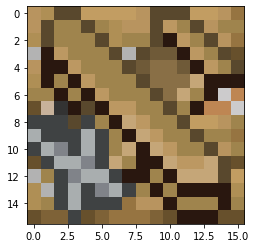

In [4]:
for dirpath, f1 in f:
    filename, file_extension = os.path.splitext(f1)
    path_join = os.path.join(dirpath, f1)
    if file_extension == ".png":
        print(path_join)
        im = cv2.imread(path_join,cv2.IMREAD_UNCHANGED)
        RGB_img = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)

        imshow(RGB_img)

        # hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
        # hchannel = hsv[:, :, 0]
        # hchannel = 100 + hchannel
        # hsv[:, :, 0] = hchannel
        # rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        # imshow(rgb)



In [63]:
import numpy as np
import cv2

def color_transfer(source, target, mask, target_mask):
    """
    Transfers the color distribution from the source to the target
    image using the mean and standard deviations of the L*a*b*
    color space.

    This implementation is (loosely) based on to the "Color Transfer
    between Images" paper by Reinhard et al., 2001.

    Parameters:
    -------
    source: NumPy array
        OpenCV image in BGR color space (the source image)
    target: NumPy array
        OpenCV image in BGR color space (the target image)

    Returns:
    -------
    transfer: NumPy array
        OpenCV image (w, h, 3) NumPy array (uint8)
    """
    # convert the images from the RGB to L*ab* color space, being
    # sure to utilizing the floating point data type (note: OpenCV
    # expects floats to be 32-bit, so use that instead of 64-bit)
    target1 = target.copy()
    source = cv2.cvtColor(source, cv2.COLOR_BGR2LAB).astype("float32")
    target = cv2.cvtColor(target, cv2.COLOR_BGR2LAB).astype("float32")

    # compute color statistics for the source and target images
    (lMeanSrc, lStdSrc, aMeanSrc, aStdSrc, bMeanSrc, bStdSrc) = image_stats(source,mask)
    (lMeanTar, lStdTar, aMeanTar, aStdTar, bMeanTar, bStdTar) = image_stats(target,target_mask)
    print(lMeanSrc, lStdSrc, aMeanSrc, aStdSrc, bMeanSrc, bStdSrc)
    print(lMeanTar, lStdTar, aMeanTar, aStdTar, bMeanTar, bStdTar)

    # subtract the means from the target image
    (l, a, b) = cv2.split(target)
    l -= lMeanTar
    a -= aMeanTar
    b -= bMeanTar

    # scale by the standard deviations
    l = (lStdTar / lStdSrc) * l
    a = (aStdTar / aStdSrc) * a
    b = (bStdTar / bStdSrc) * b

    # add in the source mean
    l += lMeanSrc
    a += aMeanSrc
    b += bMeanSrc

    # clip the pixel intensities to [0, 255] if they fall outside
    # this range
    l = np.clip(l, 0, 255)
    a = np.clip(a, 0, 255)
    b = np.clip(b, 0, 255)

    # merge the channels together and convert back to the RGB color
    # space, being sure to utilize the 8-bit unsigned integer data
    # type
    transfer = cv2.merge([l, a, b])
    transfer = cv2.cvtColor(transfer.astype("uint8"), cv2.COLOR_LAB2BGR)
    target1[target_mask] = transfer[target_mask]
    #return the color transferred image

    return target1

def image_stats(image,mask):
    """
    Parameters:
    -------
    image: NumPy array
        OpenCV image in L*a*b* color space

    Returns:
    -------
    Tuple of mean and standard deviations for the L*, a*, and b*
    channels, respectively
    """
    # compute the mean and standard deviation of each channel
    (l, a, b) = cv2.split(image)
    plt.show()
    (lMean, lStd) = (l[mask].mean(), l[mask].std())
    (aMean, aStd) = (a[mask].mean(), a[mask].std())
    (bMean, bStd) = (b[mask].mean(), b[mask].std())

    # return the color statistics
    return (lMean, lStd, aMean, aStd, bMean, bStd)

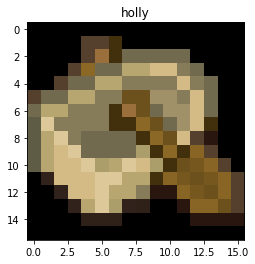

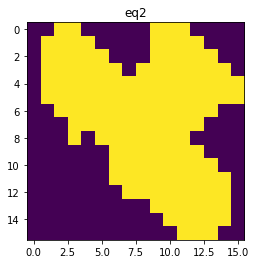

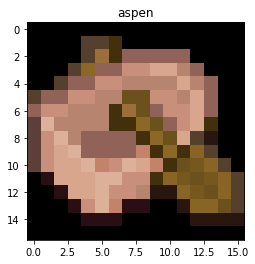

141.92523 45.017277 144.23364 2.0715225 144.2243 5.01271
140.90141 70.289375 129.24648 0.43096057 132.69014 0.8407165


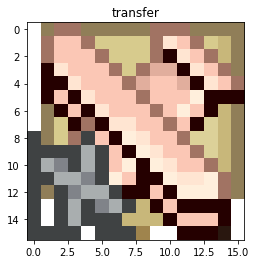

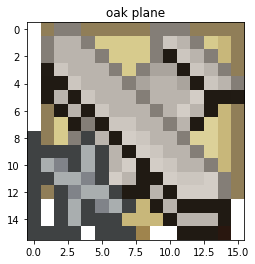

In [75]:
import matplotlib.pyplot as plt

# im1 = cv2.imread("boats\\holly_boat.png")
im1 = cv2.imread("boats\\holly_boat.png")
plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGRA2RGB))
plt.title("holly")
plt.show()

im1 = cv2.cvtColor(im1, cv2.COLOR_BGRA2BGR)
im2 = cv2.imread("boats\\aspen_boat.png")

eq1 = ~np.all(im1 == im2,axis=2)

src = cv2.imread("item\\bop_dead_plane.png", cv2.IMREAD_UNCHANGED)
im_p1 = cv2.cvtColor(src, cv2.COLOR_BGRA2BGR)
im_p2 = cv2.cvtColor(cv2.imread("item\\bop_cherry_plane.png"), cv2.COLOR_BGRA2BGR)
eq2 = ~np.all(im_p1 == im_p2,axis=2)

# im1[eq] = 0
# im2[eq] = 0
plt.imshow(eq2.astype(int))
plt.title("eq2")
plt.show()

plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGRA2RGB))
plt.title("aspen")
plt.show()
im3 = color_transfer(im2,im_p1,eq1,eq2)
plt.imshow(cv2.cvtColor(im3, cv2.COLOR_BGRA2RGB))
plt.title("transfer")
plt.show()
plt.imshow(cv2.cvtColor(im_p1, cv2.COLOR_BGRA2RGB))
plt.title("oak plane")
plt.show()


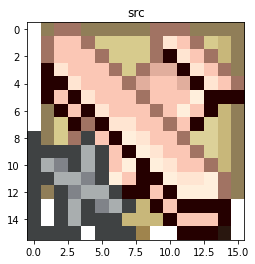

True

In [82]:
src[...,:-1] = im3
plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGRA2RGB))
plt.title("src")
plt.show()
cv2.imwrite("out/one.png",src)
